# Using scvelo to recover and analyze RNA velocity
More info on the official [scvelo documentation](https://scvelo.readthedocs.io/about.html).

### Installation
To install conda, please follow this [link](https://conda.io/projects/conda/en/latest/user-guide/install/index.html)

After installing conda, you will need to create a new conda environment, and install scvelo in this environment (all the following lines must be executed in the terminal).

In [ ]:
! conda create --name scvelo_env python=3.9 anaconda
! conda activate scvelo_env
! pip install -U scvelo

You've now installed conda and scvelo. Next time, before lauching a new notebook, you will need to activvate the environment you created.

In [ ]:
! conda activate scvelo_env
! jupyter notebook

And then you can open the notebook in the environment where scvelo is installed.

### Packages
First step is to import all the needed packages. `copy` is not mandatory, and may in fact never be used, but can be useful if you don't want to modify the base data when creating a new object from an existing one. All these packages are already base python packages, or come with scvelo and are installed at the same time.

In [1]:
import scvelo as scv
import pandas as pd
import copy
import pickle
import os
import csv
import anndata

After importing scvelo, you can verify the version.

In [2]:
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.9.4) on 2021-09-08 14:50.


## Load the Data
There are several ways to load the data. Here we will show two of them, the first one using a `.loom` file from velocyto and the metadata from Seurat in `.csv`, and the second one using the **spliced** and **unspliced** assays from a Seurat object in csv.

We decided to keep the information from the Seurat object (UMAP and metadata). We do not generate it from scvelo.

### From loom file
Read the velocyto loom file and add Seurat umap and meta data. 

In [ ]:
# export Seurat object information from R
library(Seurat)
setwd('/mnt/Data1/public_vignettes/scvelo_data')

seur <- readRDS('/mnt/Data1/public_vignettes/seurat_data/neuron_1k.rds')

write.csv(x = seur@meta.data, file = 'neuron_1k_meta.csv')
write.csv(x = seur@reductions$umap@cell.embeddings, file = 'neuron_1k_umap.csv')

In [4]:
# read loom file from velocyto
adata = scv.read_loom(filename='/mnt/Data1/public_vignettes/cellranger_output/neuron_1k/velocyto/neuron_1k.loom')
adata.var_names_make_unique()

def rename_barcode(barcodes, trim_start='', trim_end='', add_start='', add_end=''):
    """
    :param barcodes: list of barcodes to rename
    :param trim_start: characters to remove at the beginning of each barcode
    :param trim_end: characters to remove at the end of each barcode
    :return: the list of barcodes without the starting and ending characters
    """
    if trim_start != barcodes[0][0:len(trim_start)]:
        raise ValueError('trim_start not in cells')
    if trim_end != barcodes[0][-len(trim_end):]:
        raise ValueError('trim_end not in cells')
    return [add_start + i[len(trim_start): -len(trim_end)] + add_end for i in barcodes]

# use it to rename anndata cells
adata.obs_names = rename_barcode(list(adata.obs_names), trim_start = "neuron_1k:", trim_end = "x", add_end = "-1")


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:

# read umap coordinates
X_umap = scv.load('/mnt/Data1/public_vignettes/scvelo_data/neuron_1k_umap.csv', index_col=0)
# keep the cells present in the filtered Seurat object
cells = list(X_umap.index)
adata = adata[cells]
# write the Umap coordinates in obsm table (contains dimension reduction) in adata object
adata.obsm['X_umap'] = copy.deepcopy(X_umap.loc[adata.obs_names].values)

# read metadata
m = pd.read_csv("/mnt/Data1/public_vignettes/scvelo_data/neuron_1k_meta.csv", index_col='Unnamed: 0')
# write the clusters id in obs table (contains meta data) in adata object
adata.obs['clusters'] = copy.deepcopy(m['clusters'].loc[adata.obs_names].values)

You can visualize the spliced/unspliced proportions, to verify that both are well loaded, and out of curiosity too.

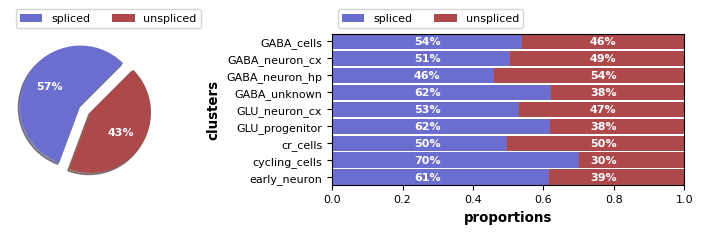

In [7]:
adata.obs['clusters'] = adata.obs['clusters'].astype('category')
scv.pl.proportions(adata, groupby='clusters')

## Preprocessing the Data
Preprocessing consist of gene selection by minimum counts, normalizing every cell by its total size, gene selection by dispersion and logarithmizing X (assay RNA in Seurat). All these steps are ran when running `scv.pp.filter_and_normalize`. Analysis further require first and second order moments (means and uncenterd variance) among nearest neighbors in PCA space. You can change the parameters as you want, here are the default values. Note that the more cells you have, the more you can increase `n_neighbors`. If you only have very few cells, you might want to reduce this parameter. You can also change the number of top genes to keep, but the more genes, the longer the velocity recovery will take.

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 23760 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Estimate RNA velocity

### Dynamical method
The dynamical method requires another step, which learn the full transcriptional dynamics of splicing kinetics. It takes much longer than the Stochastic methods, but is the most precise of all. On 11 000 cells and 2 000 genes it takes more than an hour to retrieve the full splicing kinetics, without parallelization.

In [9]:
scv.tl.recover_dynamics(adata) # the most time consuming step

scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 1/40 cores)


  0%|          | 0/1204 [00:00<?, ?gene/s]

    finished (0:03:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/1050 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Visualize the velocity
There are 3 plotting methods to visualize the velocity on a UMAP. The grid, the stream and the base (my personnal favorite is the stream, but the base one might be better for a small number of cells). There are many grahical parameters that can be changed, see the [documentation](https://scvelo.readthedocs.io/api.html) for more info

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


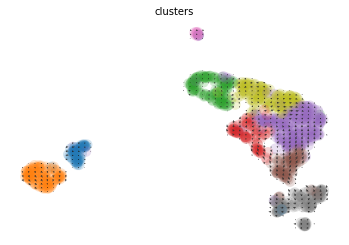

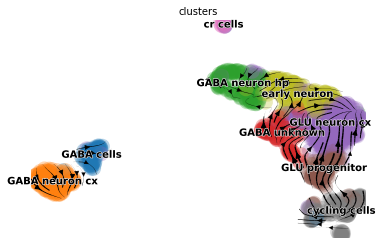

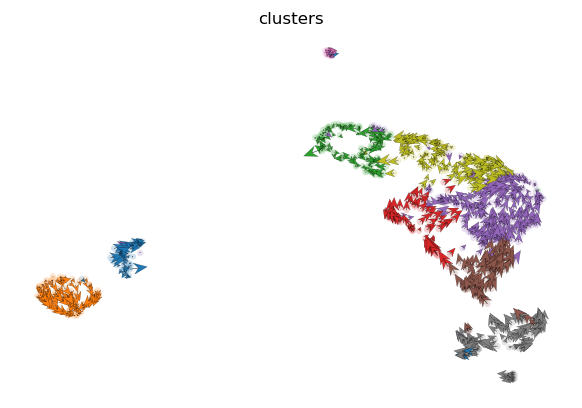

In [10]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='clusters')
scv.pl.velocity_embedding_stream(adata, basis='umap', color='clusters')
scv.pl.velocity_embedding(adata, arrow_length=4, arrow_size=4, dpi=120, color='clusters')

In [23]:
pickle.dump(adata, open('.//mnt/Data1/public_vignettes/scvelo_data/neuron_1k_dynamical.dp', 'wb'))